In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [4]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [5]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [6]:
for col in df_jhu.columns.values:
    print(col)
    print(df_jhu[col].isna().sum())

State
0
Area_Name
0
Rural-urban_Continuum Code_2013
52
Urban_Influence_Code_2013
52
Economic_typology_2015
130
POP_ESTIMATE_2018
0
N_POP_CHG_2018
79
Births_2018
79
Deaths_2018
79
NATURAL_INC_2018
79
INTERNATIONAL_MIG_2018
79
DOMESTIC_MIG_2018
79
NET_MIG_2018
79
RESIDUAL_2018
79
GQ_ESTIMATES_2018
79
R_birth_2018
79
R_death_2018
79
R_NATURAL_INC_2018
79
R_INTERNATIONAL_MIG_2018
79
R_DOMESTIC_MIG_2018
79
R_NET_MIG_2018
79
Less than a high school diploma 2014-18
0
High school diploma only 2014-18
0
Some college or associate's degree 2014-18
0
Bachelor's degree or higher 2014-18
0
Percent of adults with less than a high school diploma 2014-18
0
Percent of adults with a high school diploma only 2014-18
0
Percent of adults completing some college or associate's degree 2014-18
0
Percent of adults with a bachelor's degree or higher 2014-18
0
POVALL_2018
80
CI90LBAll_2018
80
CI90UBALL_2018
80
PCTPOVALL_2018
80
CI90LBALLP_2018
80
CI90UBALLP_2018
80
POV017_2018
80
CI90LB017_2018
80
CI90UB017_2018


In [17]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips']

In [58]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
    return set(Y.fips.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [88]:
cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
cum_deaths = cum_deaths.iloc[1:]
def get_cum_deaths(fips, clip_zeros=True):
    idx = cum_deaths.index[cum_deaths['countyFIPS'] == fips].values[0]
    county_deaths = cum_deaths.loc[cum_deaths['countyFIPS'] == fips]
    dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_deaths.columns)):
        y.append(county_deaths.loc[idx,county_deaths.columns[i]])
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            return X[i:], y[i:]

cum_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")
cum_cases = cum_cases.iloc[1:]
def get_cum_cases(fips,clip_zeros=True):
    idx = cum_cases.index[cum_cases['countyFIPS'] == fips].values[0]
    county_cases = cum_cases.loc[cum_cases['countyFIPS'] == fips]
    dates = pd.to_datetime(county_cases.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_cases.columns)):
        y.append(county_cases.loc[idx,county_cases.columns[i]])
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            return X[i:], y[i:]

In [137]:
NYT_counties_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == 1005, :]
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
def get_delta_deaths(fips, clip_zeros=False):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.deaths.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

def get_delta_cases(fips, clip_zeros=False):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.cases.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

# returns an X, y where y[i] is the number of deaths on day i divided by the running average
def get_delta_deaths_ratio(fips, clip_zeros=False, avg_period=5):
    X_raw, y_raw = get_delta_deaths(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))
def get_delta_cases_ratio(fips, clip_zeros=False, avg_period=5):
    X_raw, y_raw = get_delta_cases(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))

## Simple OLS

In [155]:
def get_XY(features, delta_y, look_back_y, get_y):
    df = df_jhu[features]
    df = df[df.fips % 1000 != 0]
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    df = df[df.POP_ESTIMATE_2018 > 100000] # restrict to large counties since getting lots of data is difficult

    # fill out missing data
    # df.at['02158', 'Area in square miles - Land area'] = 19673
    # df.at['02158', 'Density per square mile of land area - Population'] = 0.44
    # df.at['46102', 'Area in square miles - Land area'] = 2097
    # df.at['46102', 'Density per square mile of land area - Population'] = 6.5
    
    n, d = df.shape
    col_names = []
    for i in range(look_back_y):
        col_name = "y at t = -%d" %i
        col_names.append(col_name)
        df[col_name] = np.zeros(n)
    Y = []
    for fips in df.index:
        X, ys = get_y(int(fips))
        if len(ys) == 0:
            Y.append(0)
            continue
        Y.append(ys[-1])
        for i in range(look_back_y):
            if i + delta_y < len(ys):
                df.at[fips, col_names[i]] = ys[-1 - i - delta_y]
    df['target'] = Y
    return df

In [157]:
df_res = get_XY(features, 5, 5, get_delta_deaths)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [207]:
import statsmodels.api as sm
X = df_res[df_res.columns[2:-1]]
y = df_res['target']


model = sm.OLS(y,X)
result = model.fit()
print(result.summary())
print(np.corrcoef(X['y at t = -0'], y))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     839.9
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:52:35   Log-Likelihood:                -1734.7
No. Observations:                 598   AIC:                             3509.
Df Residuals:                     578   BIC:                             3597.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Augmented Dickey Fuller Test for Stationary Time Series

In [93]:
import statsmodels.tsa.stattools as ts
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -1.672929
P-Value                  0.445112
# Lags Used              1.000000
# Observations Used     27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


Conclude: time series is stationary

In [81]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = get_delta_deaths_ratio(fips, clip_zeros=True)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

## ARIMA Model

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


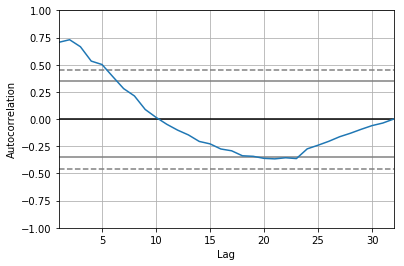

In [130]:
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163), Queens(36059), King (nyc) (36047)
X, y = get_delta_deaths(36061)
autocorrelation_plot(y)

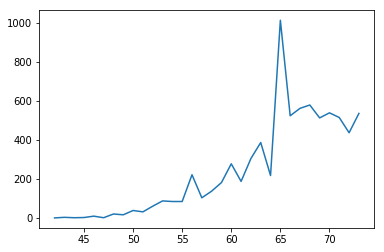

In [131]:
plt.plot(X,y)

/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1275: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k] * X[k:]).sum() / denom(k)


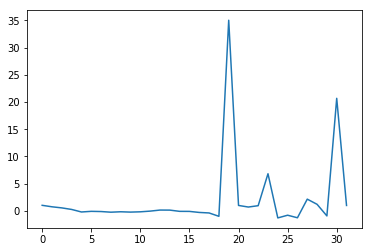

In [98]:
plt.plot(pacf(y))